## 말라리아 셀 이미지
* 말라리아 스크리너 연구 활동의 분할된 세포의 얇은 혈액 도말 슬라이드 이미지
* 리소스가 제한된 지역에서 현미경 전문가의 부담을 줄이고 진단 정확도를 개선하기 위해 NLM(National Library of Medicine)의 일부인 Lister Hill National Center for Biomedical Communications(LHNCBC)의 연구원들은 모바일 애플리케이션을 개발
* 방글라데시 치타공 의과대학 병원에서 150명의 P. falciparum 감염자와 50명의 건강한 환자의 Giemsa 염색 얇은 혈액 도말 슬라이드를 수집하고 사진을 촬영
* 적혈구를 감지하고 분할하기 위해 레벨 세트 기반 알고리즘을 적용

### 이미지 출처 
* [LHNCBC Full Download List](https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets)
* [Malaria Cell Images Dataset | Kaggle](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria)
* 관련 논문 : [Performance evaluation of deep neural ensembles toward malaria parasite detection in thin-blood smear images [PeerJ]](https://peerj.com/articles/6977/)
* 해당 논문의 github : [sivaramakrishnan-rajaraman/Deep-Neural-Ensembles-toward-Malaria-Parasite-Detection-in-Thin-Blood-Smear-Images: This study evaluates the performance of custom and pretrained CNNs and construct an optimal model ensemble toward the challenge of classifying parasitized and normal cells in thin blood smear images. The results obtained are encouraging and superior to the state-of-the-art.](https://github.com/sivaramakrishnan-rajaraman/Deep-Neural-Ensembles-toward-Malaria-Parasite-Detection-in-Thin-Blood-Smear-Images)

<img src="https://i.imgur.com/okCbMzc.png" width="400">

## 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

## 이미지 폴더 보기

In [ ]:
# 이미지 다운로드
# !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

In [ ]:
# images 폴더에 다운로드 받은 파일 압축 해제하기
# !unzip cell_images.zip

In [3]:
import os
for root, dirs, files in os.walk("./cell_images/"):
    print(root, dirs, len(files))

./cell_images/ ['Parasitized', 'Uninfected'] 0
./cell_images/Parasitized [] 13780
./cell_images/Uninfected [] 13780


## 일부 이미지 미리보기

In [4]:
import glob
upics = glob.glob('./cell_images/Uninfected/*.png')
apics = glob.glob('./cell_images/Parasitized/*.png')
len(upics), upics[0], len(apics), apics[0]

(13779,
 './cell_images/Uninfected/C132P93ThinF_IMG_20151004_151701_cell_78.png',
 13779,
 './cell_images/Parasitized/C99P60ThinF_IMG_20150918_140900_cell_136.png')

In [5]:
upics[:5]

['./cell_images/Uninfected/C132P93ThinF_IMG_20151004_151701_cell_78.png',
 './cell_images/Uninfected/C89P50ThinF_IMG_20150820_162300_cell_58.png',
 './cell_images/Uninfected/C50P11thinF_IMG_20150724_115141_cell_8.png',
 './cell_images/Uninfected/C207ThinF_IMG_20151029_144033_cell_51.png',
 './cell_images/Uninfected/C163P124ThinF_IMG_20151116_111742_cell_139.png']

In [6]:
upics[:5]

['./cell_images/Uninfected/C132P93ThinF_IMG_20151004_151701_cell_78.png',
 './cell_images/Uninfected/C89P50ThinF_IMG_20150820_162300_cell_58.png',
 './cell_images/Uninfected/C50P11thinF_IMG_20150724_115141_cell_8.png',
 './cell_images/Uninfected/C207ThinF_IMG_20151029_144033_cell_51.png',
 './cell_images/Uninfected/C163P124ThinF_IMG_20151116_111742_cell_139.png']

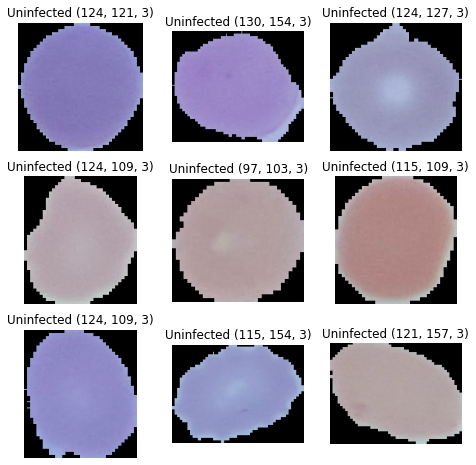

In [7]:
# cv2 로 Uninfected 시각화
import cv2

plt.figure(figsize=(8, 8))
labels = "Uninfected"
for i, images in enumerate(upics[:9]):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(images)
    plt.imshow(img)
    plt.title(f'{labels} {img.shape}')
    plt.axis("off")

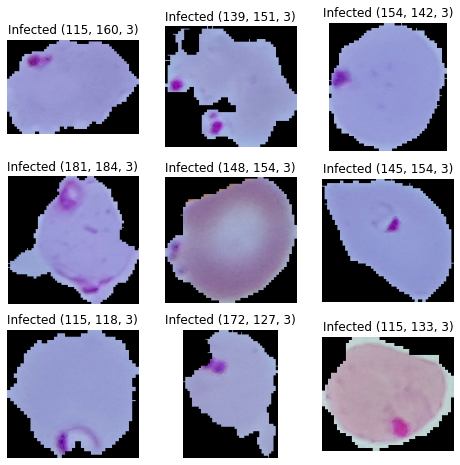

In [8]:
# cv2 로 Infected 시각화
plt.figure(figsize=(8, 8))
labels = "Infected"

for i, images in enumerate(apics[:9]):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(images)
    plt.imshow(img)
    plt.title(f'{labels} {img.shape}')
    plt.axis("off")

## 데이터셋 나누기
* 학습, 검증 세트를 나눕니다.

In [9]:
# ImageDataGenerator 를 통해 이미지를 로드하고 전처리 합니다.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# validation_split 값을 통해 학습:검증 비율을 8:2 로 나눕니다.
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

## 이미지 사이즈 설정
* 이미지의 사이즈가 불규칙하면 학습을 할 수 없기 때문에 리사이즈할 크기를 지정합니다.

In [33]:
# 원본 이미지는 100~200 내외입니다.
width = 32
height = 32

### 학습 세트

In [34]:
# flow_from_directory 를 통해 이미지를 불러옵니다.
trainDatagen = datagen.flow_from_directory(directory = 'cell_images/',
                                           target_size = (height, width),
                                           class_mode = 'binary',
                                           batch_size = 64,
                                           subset='training')

Found 22048 images belonging to 2 classes.


### 검증 세트

In [35]:
valDatagen = datagen.flow_from_directory(directory = 'cell_images/',
                                         target_size =(height, width),
                                         class_mode = 'binary',
                                         batch_size = 64,
                                         subset='validation')

Found 5510 images belonging to 2 classes.


## 레이어 설정

* [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)와 [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) 층을 쌓는 일반적인 패턴으로 합성곱 층을 정의합니다.
 
* CNN은 배치(batch) 크기를 제외하고 (이미지 높이, 이미지 너비, 컬러 채널) 크기의 텐서(tensor)를 입력으로 받습니다. 
* 컬러 이미지는 (R,G,B) 세 개의 채널을 가집니다. (흑백 이미지는 채널이 하나 입니다.)

* 컨볼루션 과정 참고 : https://cs231n.github.io/convolutional-networks/

* filters : 컨볼루션 필터의 수 >> 필터 수 = 특징맵 수
* kernel_size : 컨볼루션 커널의 (행, 열)  >> 필터 사이즈
* padding : 경계 처리 방법
    * ‘valid’ : 유효한 영역만 출력이 됩니다. 따라서 출력 이미지 사이즈는 입력 사이즈보다 작습니다.
    * ‘same’ : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일합니다.
* input_shape : 모델에서 첫 레이어에서 정의 (height, width, channels)
*  activation : 활성화 함수 설정
    * ‘linear’ : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력
    * ‘relu’ : rectifier 함수, 은닉층에 주로 사용
    * ‘sigmoid’ : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 사용
    * ‘softmax’ : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 사용

* Dense Layer: 
    * 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 
    * 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 
    * 마지막 층은 출력층 입니다.
        * 소프트맥스 일 때 : 2개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 2개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 
        * 각 노드는 현재 이미지가 2개 클래스 중 하나에 속할 확률을 출력합니다.
        * 시그모이드 일 때 : 둘 중 하나를 예측할 때 1개의 출력값을 출력합니다. 확률을 받아 임계값 기준으로 True, False로 나눕니다.
    
    
* 출력층 :
    * 예측 값이 n개 일 때 :  tf.keras.layers.Dense(n, activation='softmax')
    * 예측 값이 둘 중 하나일 때 : tf.keras.layers.Dense(1, activation='sigmoid')
    

* 합성곱 신경망 : https://www.tensorflow.org/tutorials/images/cnn

In [36]:
import tensorflow
print(dir(tensorflow.keras.applications))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


In [50]:
# tensorflow.keras.applications.vgg19에서 19개의 층을 사용하는 VGG19 모델을 불러옵니다.
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(height, width, 3))

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

In [51]:
# tensorflow.keras.applications.resnet50 에서 ResNet50 을 불러옵니다.


## 모델 요약

In [52]:
# summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


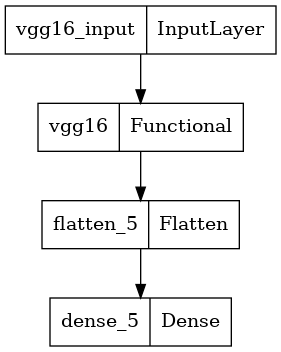

In [53]:
# tensorflow.keras.utils의 plot_model 을 통한 레이어 시각화
from tensorflow.keras.utils import plot_model

plot_model(model)

## 컴파일


모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 컴파일 단계에서 추가됩니다:

* 옵티마이저(Optimizer) - 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
* 지표(Metrics) - 훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.


* 손실 함수(Loss function) - 훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다. 최적의 가중치를 찾도록 해야함
    * 회귀  : MSE, MAE
    * 분류 : 
        * 바이너리(예측할 값의 종류가 둘 중 하나) : 
            * binary_crossentropy
        * 멀티클래스(예측할 값의 종류가 2개 이상) : 
            * categorical_crossentropy(one-hot형태의 클래스 예: [0, 1, 0, 0])
            * sparse_categorical_crossentropy(정답값이 0, 1, 2, 3, 4 와 같은 형태일 때)

In [54]:
# compile
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["accuracy"])

## 학습

* 배치(batch): 모델 학습에 한 번에 입력할 데이터셋
* 에폭(epoch): 모델 학습시 전체 데이터를 학습한 횟 수
* 스텝(step): (모델 학습의 경우) 하나의 배치를 학습한 횟 수
* EarlyStopping: 성능이 더 이상 좋아지지 않으면 학습을 중지
    * early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [55]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
# fit
history = model.fit(trainDatagen, validation_data=valDatagen, epochs=10)
history

Epoch 1/10
269/345 [======================>.......] - ETA: 5:55 - loss: 0.3548 - accuracy: 0.8360

In [ ]:
# history
history